# Pseudo-random number sequences classifier

The following notebook applies the language models fitted in [prng_deepzoom_lm.ipynb](prng_deepzoom_lm.ipynb) for the classification of the sequence samples generated with deep-zoom method as described in Machicao, J., & Bruno, O. M. (2017). Improving the pseudo-randomness properties of chaotic maps using deep-zoom. Chaos: An Interdisciplinary Journal of Nonlinear Science, 27(5), 53116.

## Dataset
Data consists of a training set and a test set, each with 100 sample files divided in 11 classes.

Each class corresponds to sequences generated with the deep zoom method using a different value of k, respectively from k=0 to k=10

Each sample file contains a sequence of one million digits produced using deep zoom with the corresponding value of k.

Files are in text format, using the following naming convention: /{Train|Test}/k{k}/k{k}-parte{0-99}.ser

## Classes and functions

In [1]:
import numpy as np
from RNNLanguageModel import *
from utilities import *
%matplotlib inline

class MultiClassSequenceClassifier(object):
  
  def __init__(self,
               models_dict = [{'k': 0, 'log_dir': '/tmp/RNNLanguageModel/k0'}, 
                              {'k': 1, 'log_dir': '/tmp/RNNLanguageModel/k1'}, 
                              {'k': 2, 'log_dir': '/tmp/RNNLanguageModel/k2'}, 
                              {'k': 3, 'log_dir': '/tmp/RNNLanguageModel/k3'}, 
                              {'k': 4, 'log_dir': '/tmp/RNNLanguageModel/k4'}, 
                              {'k': 5, 'log_dir': '/tmp/RNNLanguageModel/k5'}, 
                              {'k': 6, 'log_dir': '/tmp/RNNLanguageModel/k6'}, 
                              {'k': 9, 'log_dir': '/tmp/RNNLanguageModel/k9'}
                             ]
              ):
    self.models_dict = models_dict
    self._supported_models = [m['k'] for m in self.models_dict]
    np.random.seed(0)
    

  def predict_proba(self, x):
    x = np.array(x)
    if np.ndim(x) == 1:
      x = np.reshape(x, (1, -1))
    assert np.ndim(x) == 2

    sequence_size = x.shape[1]
    step_size = min(sequence_size, 32)
    num_samples = x.shape[0]
    batch_size = min(192, sequence_size // step_size)
    num_models = len(self._supported_models)
    
    log_probabilities = np.zeros((num_samples, num_models))
      
    for i in range(num_models):
      model_info = self.models_dict[i]
      model = RNNLanguageModel(step_size = step_size,
                               batch_size = batch_size,
                               log_dir = model_info['log_dir'])
      
      print('Evaluating data against model for k={}'.format(model_info['k']))
      log_probabilities[:,i] = model.predict_log_proba(x)
    
    y_probabilities = softmax(log_probabilities)

    return y_probabilities

      
  def predict(self, x):
    probabilities = self.predict_proba(x)
    indices = np.argmax(probabilities, 1)
    predictions = [self.models_dict[i]['k'] for i in indices]
    return (predictions, probabilities)
    


In [2]:
def sample_from_testset(ks = [0, 1, 2, 3, 4, 5, 6, 9], 
                   samples_per_k = 100,
                   sample_len = 100000
                  ):
  X = np.zeros((len(ks) * samples_per_k, sample_len))
  Y = np.zeros(len(ks) * samples_per_k)
  for i, k in enumerate(ks):
    data = load_data(k=k, path_pattern = 'data/DatasetKlogmap/Test/k%d/k%d-parte%d.ser', indices=range(samples_per_k))
    data = np.array(data)
    data = data.reshape((samples_per_k, -1))
    X[i * samples_per_k : (i + 1) * samples_per_k] = data[:,:sample_len]
    Y[i * samples_per_k : (i + 1) * samples_per_k] = k
  return X, Y

# Evaluation of the models on the classification task

* Evaluation is made on models trained for $k \in \{0, 1, 2, 3, 4, 5, 6, 9\}$
* Models were trained with only the first 20 files from the Train set, with the exception of k=4, which was allowed to train with the whole train set. 
* Evaluation is made with samples from the Test set. For this evaluation, only the first 100,000 digits from the first 10 test files for each class k were fed to the models for classification.

In [3]:
X_test, Y_test = sample_from_testset(samples_per_k = 10)

Loading data for k=0, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Loading data for k=1, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]


Loading data for k=2, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


Loading data for k=3, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


Loading data for k=4, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


Loading data for k=5, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


Loading data for k=6, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


Loading data for k=9, indices= range(0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


In [4]:
classifier = MultiClassSequenceClassifier()

In [5]:
(predictions, probabilities) = classifier.predict(X_test)

Evaluating data against model for k=0
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k0/checkpoints/20180129-000608-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:33<00:00, 18.42s/it]


Evaluating data against model for k=1
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k1/checkpoints/20180129-132650-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:38<00:00, 18.48s/it]


Evaluating data against model for k=2
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k2/checkpoints/20180201-173149-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:38<00:00, 18.48s/it]


Evaluating data against model for k=3
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k3/checkpoints/20180131-010735-8244-8244


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:36<00:00, 18.45s/it]


Evaluating data against model for k=4
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k4/checkpoints/20180131-051737-16277-16277


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:37<00:00, 18.47s/it]


Evaluating data against model for k=5
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k5/checkpoints/20180202-121506-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:41<00:00, 18.51s/it]


Evaluating data against model for k=6
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k6/checkpoints/20180129-064628-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:39<00:00, 18.49s/it]


Evaluating data against model for k=9
INFO:tensorflow:Restoring parameters from /tmp/RNNLanguageModel/k9/checkpoints/20180129-100630-3256-3256


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [24:37<00:00, 18.47s/it]


In [7]:
import pandas as pd

class_names = ['k={}'.format(k) for k in [0, 1, 2, 3, 4, 5, 6, 9]]
results_table = pd.DataFrame(probabilities, columns=class_names)
results_table['Prediction'] = predictions
results_table['True label'] = Y_test
results_table

,k=0,k=1,k=2,k=3,k=4,k=5,k=6,k=9,Prediction,True label
0,0.521270,0.017194,0.031538,0.021819,0.091882,0.106044,0.105136,0.105117,0,0.0
1,0.520485,0.017353,0.031890,0.022179,0.092153,0.105923,0.105023,0.104994,0,0.0
2,0.520967,0.017330,0.031584,0.021917,0.092007,0.106010,0.105106,0.105079,0,0.0
3,0.521055,0.017325,0.031485,0.021860,0.092127,0.105986,0.105095,0.105067,0,0.0
4,0.521008,0.017284,0.031781,0.022133,0.091768,0.105964,0.105043,0.105018,0,0.0
5,0.521337,0.016940,0.031552,0.021749,0.092084,0.106059,0.105148,0.105132,0,0.0
6,0.521113,0.017304,0.031571,0.021694,0.092189,0.105985,0.105082,0.105062,0,0.0
7,0.520845,0.017262,0.031844,0.021955,0.092078,0.105953,0.105048,0.105015,0,0.0
8,0.520879,0.017308,0.031899,0.022020,0.091896,0.105939,0.105041,0.105017,0,0.0
9,0.520754,0.017401,0.031932,0.021983,0.091830,0.105977,0.105077,0.105045,0,0.0


In [6]:
from sklearn import metrics
print ( 'Accuracy  : ', metrics.accuracy_score(Y_test, predictions) )

Accuracy  :  0.8625


In [9]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions, target_names=class_names))

             precision    recall  f1-score   support

        k=0       1.00      1.00      1.00        10
        k=1       1.00      1.00      1.00        10
        k=2       1.00      1.00      1.00        10
        k=3       1.00      1.00      1.00        10
        k=4       1.00      1.00      1.00        10
        k=5       0.71      1.00      0.83        10
        k=6       0.50      0.50      0.50        10
        k=9       0.67      0.40      0.50        10

avg / total       0.86      0.86      0.85        80



[[10  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  3  5  2]
 [ 0  0  0  0  0  1  5  4]]


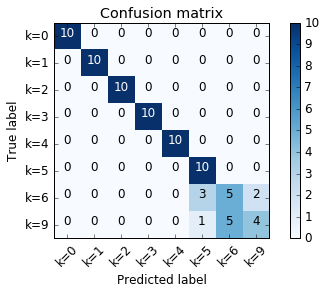

In [8]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(Y_test, predictions)
np.set_printoptions(precision=2)

print(cnf_matrix)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')

plt.show()


## Preliminary results and discussion

* Model for k=6 and k=9 were not considered to have trained succesfully. They both produced a perplexity of 10.00 and accuracy of 0.100 during training, which intuitively implies that they did not reach to the point of detecting a pattern other than a uniform random distribution.
* As a consequence, confusion matrix results for k=6 and k=9 are comparable to random guessing.
* On the other side, for every other class that did capture a pattern, even just a couple of points above uniformly random guessing, recall gets to 100%
* Removing k=6 and k=9 from the matrix would push accuracy to 100%
* Preliminary results are very encouraging, especially given that the models have been trained with only a fraction of the data, and that neither architecture nor the network hyperparameters have been tuned optimally.